In [49]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier, Pool
from ngboost import NGBClassifier
from ngboost.scores import LogScore, CRPScore
from ngboost.distns import k_categorical
from sklearn.preprocessing import *
from scipy.stats import chisquare, chi2_contingency

- 2021.04.21 : 0.7208692899


### 변수 설명

< features >
    
- gender : 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
- edu_type: 교육 수준
- family_type: 결혼 여부
- house_type: 생활 방식
- DAYS_BIRTH: 출생일
- DAYS_EMPLOYED: 업무 시작일(양수값은 고용상태가 아님)
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월


< target >
- credit: 사용자의 신용카드 대금 연체를 기준의 신용도

In [50]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]

In [51]:
train.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [52]:
test.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0


#### FLAG_MOBIL 변수는 불필요함.

In [53]:
train.drop('FLAG_MOBIL', axis = 1, inplace = True)
test.drop('FLAG_MOBIL', axis = 1, inplace = True)

In [54]:
train['begin_month'] /= (-12)
test['begin_month'] /= (-12)

In [55]:
train.at[train[train.income_type == 'Student'].index, 'income_type'] = 'Working'
test.at[test[test.income_type == 'Student'].index, 'income_type'] = 'Working'

In [56]:
train.at[train[train.DAYS_EMPLOYED > 20000].index, 'occyp_type'] = 'No job'
test.at[test[test.DAYS_EMPLOYED > 20000].index, 'occyp_type'] = 'No job'

In [57]:
train[['DAYS_BIRTH', 'DAYS_EMPLOYED']] /= (-365)
test[['DAYS_BIRTH', 'DAYS_EMPLOYED']] /= (-365)

In [58]:
train.fillna('Unknown', inplace = True)
test.fillna('Unknown', inplace = True)

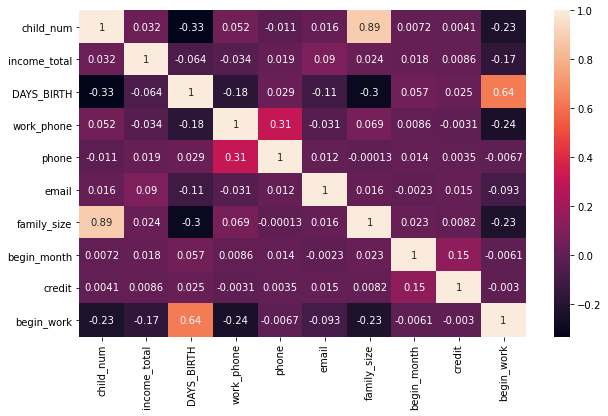

In [26]:
plt.figure(figsize = (10, 6))
sns.heatmap(train.corr(), annot = True)
plt.show()

***

In [59]:
scaler = StandardScaler()

In [60]:
tr_scaled = scaler.fit_transform(train[['child_num', 'family_size', 'begin_month', 'income_total', 'DAYS_BIRTH']])#, 'begin_work']])#, 'per_income', 'job_income']])

In [61]:
te_scaled = scaler.transform(test[['child_num', 'family_size', 'begin_month', 'income_total', 'DAYS_BIRTH']])#, 'begin_work']])#, 'per_income', 'job_income']])

In [62]:
train[['child_num', 'family_size', 'begin_month', 'income_total', 'DAYS_BIRTH']] = tr_scaled#, 'begin_work']] = tr_scaled#, 'per_income', 'job_income']] = tr_scaled

In [63]:
test[['child_num', 'family_size', 'begin_month', 'income_total', 'DAYS_BIRTH']] = te_scaled#, 'begin_work']] = te_scaled#, 'per_income', 'job_income']] = te_scaled

In [64]:
train2 = pd.get_dummies(columns = train.columns[train.dtypes == 'object'], data = train)

In [65]:
test2 = pd.get_dummies(columns = test.columns[test.dtypes == 'object'], data = test)

In [66]:
skf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 413)

In [67]:
cat_pred = np.zeros((test2.shape[0], 3))
cat_val_logloss = []
i = 0
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'=========================={i} FOLD=========================')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    cat = CatBoostClassifier(iterations = 4000, early_stopping_rounds = 500, loss_function = 'MultiClass', random_state = 413, silent = True, depth = 7)
    cat.fit(tr_x, tr_y, eval_set = Pool(val_x, val_y), use_best_model = True)
    val_logloss = cat.best_score_['validation']['MultiClass']
    print(f'Logloss of Validation = {val_logloss}\n')
    cat_val_logloss.append(val_logloss)
    pred = cat.predict_proba(test2) / 8
    cat_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(cat_val_logloss)}')

==========================1 FOLD=========================
Logloss of Validation = 0.7280088293219721

==========================2 FOLD=========================
Logloss of Validation = 0.7410750126879984

==========================3 FOLD=========================
Logloss of Validation = 0.7369565634905453

==========================4 FOLD=========================
Logloss of Validation = 0.7208290315604856

==========================5 FOLD=========================
Logloss of Validation = 0.7383822715164908

==========================6 FOLD=========================
Logloss of Validation = 0.7328088169790505

==========================7 FOLD=========================
Logloss of Validation = 0.7317140442809056

==========================8 FOLD=========================
Logloss of Validation = 0.7451236612817086

==========================Finished!=========================

평균 logloss는 0.7343622788898947


In [68]:
lgb_pred = np.zeros((test2.shape[0], 3))
lgb_losses = []
i = 0
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'========================================{i} FOLD==========================================\n')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    
    lgb = LGBMClassifier(n_jobs = -1, num_iterations = 1500, metric = 'multi_logloss', objective = 'multiclass', boosting_type = 'gbdt', n_estimators = 800, random_state = 413, max_depth = 6)
    
    lgb.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)],
            early_stopping_rounds = 400, verbose = 500, eval_metric = 'multi_logloss')
    print(lgb.best_score_['valid_1']['multi_logloss'])
    lgb_losses.append(lgb.best_score_['valid_1']['multi_logloss'])
    pred = lgb.predict_proba(test2) / 8
    lgb_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(lgb_losses)}')

========================================1 FOLD==========================================

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 400 rounds
[500]	training's multi_logloss: 0.477923	valid_1's multi_logloss: 0.740744
Early stopping, best iteration is:
[397]	training's multi_logloss: 0.518141	valid_1's multi_logloss: 0.738915
0.7389152586515417
========================================2 FOLD==========================================

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 400 rounds
[500]	training's multi_logloss: 0.473963	valid_1's multi_logloss: 0.743451
Early stopping, best iteration is:
[525]	training's multi_logloss: 0.465347	valid_1's multi_logloss: 0.743012
0.7430115922142705
============================

In [69]:
xgb_pred = np.zeros((test2.shape[0], 3))
i = 0
xgb_losses = []
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'=========================={i} FOLD=========================')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    
    xgb = XGBClassifier(n_jobs = -1, objective = 'multi:softprob', n_estimators = 750, random_state = 413, max_depth = 6)
    
    xgb.fit(tr_x, tr_y, eval_metric = 'mlogloss', eval_set = [(tr_x, tr_y), (val_x, val_y)],
            early_stopping_rounds = 250, verbose = 500)
    p = xgb.predict_proba(val_x, ntree_limit = xgb.best_iteration)
    print(log_loss(val_y, p))
    xgb_losses.append(log_loss(val_y, p))
    pred = xgb.predict_proba(test2, ntree_limit = xgb.best_iteration) / 8
    xgb_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(xgb_losses)}')

==========================1 FOLD=========================
[0]	validation_0-mlogloss:0.97470	validation_1-mlogloss:0.97689
[458]	validation_0-mlogloss:0.30493	validation_1-mlogloss:0.76281
0.733239357186844
==========================2 FOLD=========================
[0]	validation_0-mlogloss:0.97409	validation_1-mlogloss:0.97765
[466]	validation_0-mlogloss:0.30110	validation_1-mlogloss:0.76851
0.7396604491281992
==========================3 FOLD=========================
[0]	validation_0-mlogloss:0.97455	validation_1-mlogloss:0.97799
[422]	validation_0-mlogloss:0.32070	validation_1-mlogloss:0.75238
0.7294139260297181
==========================4 FOLD=========================
[0]	validation_0-mlogloss:0.97396	validation_1-mlogloss:0.97872
[440]	validation_0-mlogloss:0.31433	validation_1-mlogloss:0.73109
0.7145866144423595
==========================5 FOLD=========================
[0]	validation_0-mlogloss:0.97435	validation_1-mlogloss:0.97841
[413]	validation_0-mlogloss:0.32435	validation_1-ml

0.7409 / 0.7412 / 0.72985

In [45]:
submission = pd.read_csv('sample_submission.csv')

In [70]:
submission.iloc[:, 1:] = xgb_pred * .4 + lgb_pred * .3 + cat_pred * .3

In [71]:
submission

,index,0,1,2
0,26457,0.037056,0.086766,0.876178
1,26458,0.211175,0.164461,0.624364
2,26459,0.059019,0.117748,0.823233
3,26460,0.137450,0.129199,0.733351
4,26461,0.070811,0.153281,0.775908
...,...,...,...,...
9995,36452,0.228262,0.209747,0.561990
9996,36453,0.162307,0.345132,0.492561
9997,36454,0.016528,0.064102,0.919370
9998,36455,0.076740,0.204012,0.719248


In [72]:
submission.to_csv('0419submission.csv', index = False)

0.7208692899
